# Import dependencies

In [33]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
from itertools import product
from collections import ChainMap

import torch
from torch.utils.tensorboard import SummaryWriter

from clustering import clustering_classification

# Config Params

In [34]:
TEST_SIZE = 0.8
RANDOM_SEED = 42
K_FOLDS = 5

# Our chosen datasets
TODO
We have chosen the datasets based on the following criteria:
- datasets where we do not need to do any special preprocessing so that it is easy to do in only one pipeline
- rather small datasets to ensure we do not need high computational power

In [35]:
# Dataset that seems useful
dataset_id = {"iris": 53,
              "heart_disease": 45,
              "wine_quality": 186,
              "breast_cancer_wisconsin": 17,
              "car_evaluation": 19, # Not good maybe remove
              "abalone": 1,
              "mushroom": 73, # a lot of categorical data
              "statlog" : 144, # german credit
              "student_performance" : 320,
              "accute_inflammation" : 284,
              "credit_approval" : 143,
              "wholesale_customers" : 292,
              "glass_identifcation" : 42,
              "ilpd" : 225,
              "hcv" : 503,
              "land_mines" : 763,
              "balance_scale" : 12
              }


# Import and preprocess datasets
For the preprocessing we will do the following steps:
1. Remove any missing values. In the article the following is written: "Given that our classifiers are not oriented to data with missing features, the missing inputs are treated as zero, which should not bias the comparison results." We therefore also decided to just remove missing values and to more focus on the full pipeline instead of single datasets. Another way could have been interpolation.
2. Encode categorical data into numerical data. This we have to do to use the classifiers later on.
3. Remove certain columns if they are highly correlated to others.
4. Split the data into a train and a test set. We will use a 80/20 split.
5. Scale the data so that we have zero mean and standard deviation of one. This is done with the Standard scaler.

In [36]:
# function for converting categorical features into numerical
def encode_categorical_features(X, encoder):
    X = encoder.fit_transform(X)
    return X

In [37]:
def import_dataset(uci_id, encoder):
    # get the dataset
    dataset = fetch_ucirepo(id=uci_id) 
    # load data into dataframe for easier preprocessing
    df = pd.concat([dataset["data"]["features"],dataset["data"]["targets"] ],axis=1)
    # remove nan values
    df.dropna(inplace=True)
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1:]
    # encode categorical data only for features not for target itself
    # https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical
    cols = X.columns
    num_cols = X._get_numeric_data().columns
    #print(num_cols)
    categorical_cols = list(set(cols) - set(num_cols))
    #print(categorical_cols)
    X.loc[:, categorical_cols] = encode_categorical_features(X[categorical_cols], encoder)
    
    # check if encoding has worked
    # https://stackoverflow.com/questions/26924904/check-if-dataframe-column-is-categorical
    for c in X.columns:
        if X[c].dtype.name == "category":
            print(f"WARNING: Column {c} still has categorical values!")
            
    # last column is target
    return X, y

In [38]:
ordinal_encoder = OrdinalEncoder()
X, y = import_dataset(dataset_id["glass_identifcation"], ordinal_encoder)
y = encode_categorical_features(y, ordinal_encoder)

In [39]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# For logging 

In [40]:
writer = SummaryWriter()

train_acc_dict = {}
train_f1_dict = {}
test_acc_dict = {}
test_f1_dict = {}

In [41]:
# Launch tensorboard
%tensorboard --logdir runs/ --port 6006
# If in use (Mac) use to find the process PID
% lsof -i :6006
# Kill the process with 
% kill -9 <PID>
# Then launch using bash with first command

UsageError: Line magic function `%tensorboard` not found.


# Testing different classifiers

In [42]:
def test_classifier(clf, clf_name, params, X_train, y_train, X_test, y_test):
    labels = np.unique(y_train)
    if clf_name == "kmeans":
        y_pred_train, y_pred_test = kmeans_classification(X_train, y_train, X_test)
    elif clf_name == "affinity_propagation":
        y_pred_train, y_pred_test = affinity_propagation_classification(X_train, y_train, X_test, params)
    else:
        # https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
        pipe = Pipeline([('scaler', StandardScaler()), (clf_name, clf)])
        scoring = 'accuracy'
        gs_knn = GridSearchCV(pipe,
                            param_grid=params,
                            scoring=scoring,
                            cv=5)

        # Ravel to convert from (len, 1) shape to (len,), warning from sk-learn
        y_train = np.ravel(y_train)

        gs_knn.fit(X_train, y_train)
        print(gs_knn.best_params_)
        # find best model score
        y_pred_train = gs_knn.best_estimator_.predict(X_train)
        y_pred_test = gs_knn.best_estimator_.predict(X_test)
    train_acc = accuracy_score(y_train, y_pred_train)
    # TODO
    train_f1 = f1_score(y_train, y_pred_train, average="weighted")
    #train_score = gs_knn.score(X_train, y_train)

    # test on test set
    test_acc = accuracy_score(y_test, y_pred_test)
    # TODO
    test_f1 = f1_score(y_test, y_pred_test, average="weighted")
    #test_score = gs_knn.score(X_test, y_test)

    print(f"{clf_name}, Train accuracy = {train_acc}, Test accuracy = {test_acc}")
    print(f"{clf_name}, Train f1-score = {train_f1}, Test f1-score = {test_f1}")

    # Confusion Matrix
    print("Confusion Matrix for train set")
    cm_train = confusion_matrix(y_train, y_pred_train, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
    disp.plot()
    plt.show()

    print("Confusion Matrix for test set")
    cm_test = confusion_matrix(y_test, y_pred_test, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
    disp.plot()
    plt.show()

    train_acc_dict[clf_name] = train_acc
    train_f1_dict[clf_name] = train_f1
    test_acc_dict[clf_name] = test_acc
    test_f1_dict[clf_name] = test_f1


# K-Nearest Neighbor classifier

/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


{'knn__leaf_size': 15, 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
knn, Train accuracy = 0.6904761904761905, Test accuracy = 0.627906976744186
knn, Train f1-score = 0.6783052743643877, Test f1-score = 0.5893007799940163
Confusion Matrix for train set


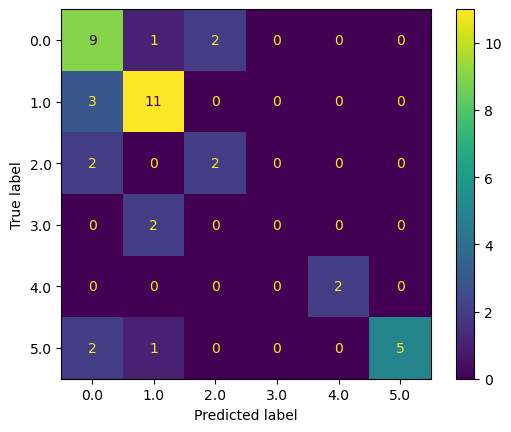

Confusion Matrix for test set


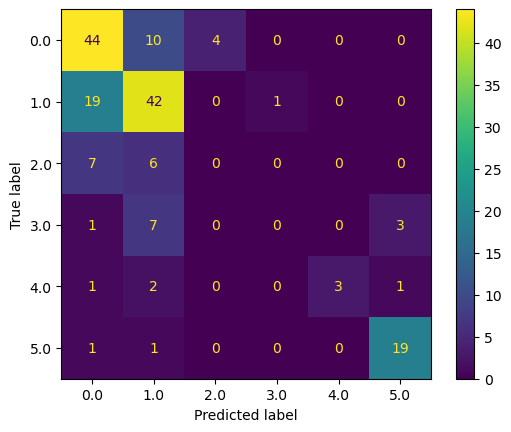

In [43]:
# https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
knn = KNeighborsClassifier()
params = [{'knn__n_neighbors': [3, 5, 7, 9],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [15, 20]}]

test_classifier(knn, "knn", params, X_train, y_train, X_test, y_test)


# SVM

/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
svm, Train accuracy = 0.8809523809523809, Test accuracy = 0.686046511627907
svm, Train f1-score = 0.8766788766788766, Test f1-score = 0.6682195328325615
Confusion Matrix for train set


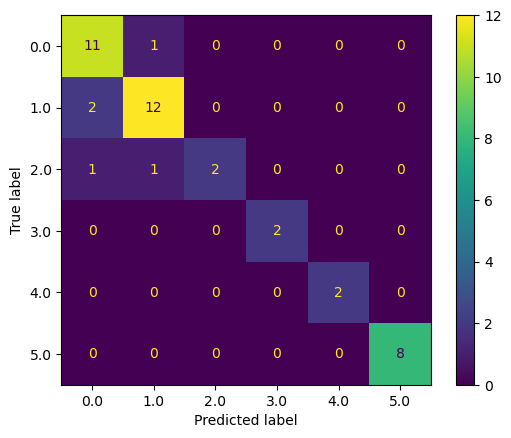

Confusion Matrix for test set


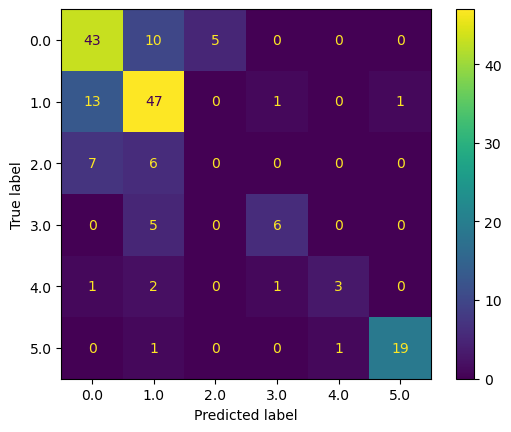

In [44]:
svm = SVC()
# params taken from here: https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
params = [{'svm__C': [0.1, 1, 10, 100, 1000],  
              'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'svm__kernel': ['rbf']} ]

test_classifier(svm, "svm", params, X_train, y_train, X_test, y_test)

# Linear Regression

/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: Convergenc

{'log_reg__max_iter': 100, 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga'}
log_reg, Train accuracy = 0.6428571428571429, Test accuracy = 0.5523255813953488
log_reg, Train f1-score = 0.5843317972350229, Test f1-score = 0.4918614037365074
Confusion Matrix for train set


/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
150 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

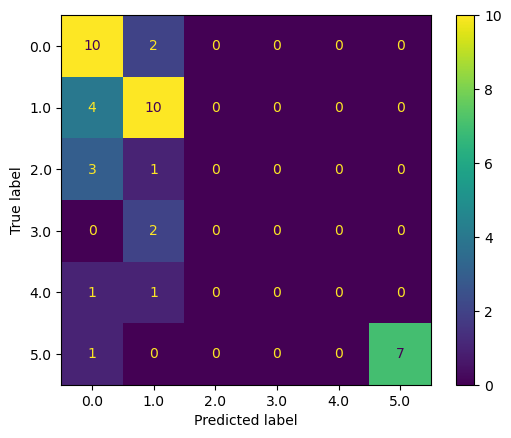

Confusion Matrix for test set


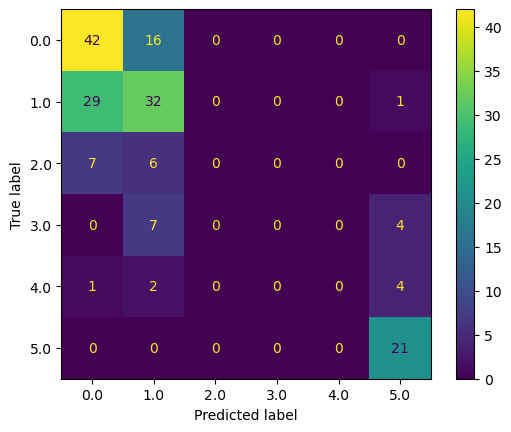

In [45]:
log_reg = LogisticRegression()
# params taken from here: https://www.geeksforgeeks.org/how-to-optimize-logistic-regression-performance/
params = [
    {'log_reg__penalty':['l1','l2','elasticnet','none'],
    #'log_reg__C' : np.logspace(-4,4,10),
    'log_reg__solver': ['lbfgs','newton-cg','liblinear','saga'],
    'log_reg__max_iter'  : [100,2500,5000]
}
]

test_classifier(log_reg, "log_reg", params, X_train, y_train, X_test, y_test)

# K-means clustering classification

----------------------------------------------------------------------------------------------------
Params:  {'n_clusters': 6}
Cross validation average train accuracy: 0.46452762923351154
Cross validation average validation accuracy: 0.2111111111111111
----------------------------------------------------------------------------------------------------
Params:  {'n_clusters': 3}
Cross validation average train accuracy: 0.41087344028520506
Cross validation average validation accuracy: 0.2611111111111111
Best params:  {'n_clusters': 3}
{'n_clusters': 3}
kmeans, Train accuracy = 0.4523809523809524, Test accuracy = 0.46511627906976744
kmeans, Train f1-score = 0.32952668246785893, Test f1-score = 0.3117316112742102
Confusion Matrix for train set


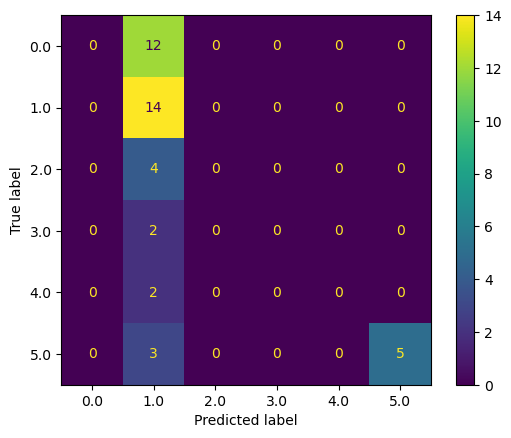

Confusion Matrix for test set


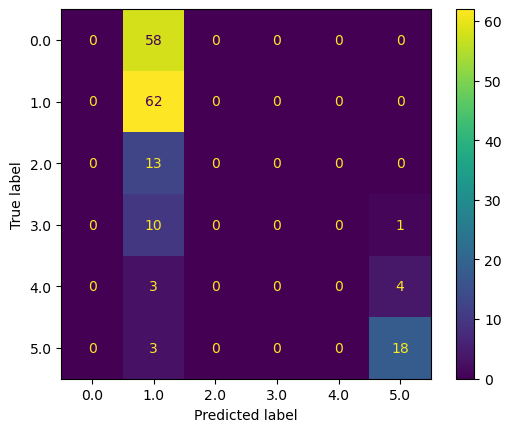

In [46]:
n_clusters = len(np.unique(y_train))
params = [{"n_clusters": [n_clusters, int(n_clusters/2)]}]
cls_name = "kmeans"

train_acc, train_f1, test_acc, test_f1 = clustering_classification(KMeans, cls_name, params, X_train, y_train, X_test, y_test, RANDOM_SEED, K_FOLDS)
train_acc_dict[cls_name] = train_acc
train_f1_dict[cls_name] = train_f1
test_acc_dict[cls_name] = test_acc
test_f1_dict[cls_name] = test_f1

----------------------------------------------------------------------------------------------------
Params:  {'convergence_iter': 10, 'damping': 0.5}
Cross validation average train accuracy: 0.4880570409982175
Cross validation average validation accuracy: 0.18611111111111112
----------------------------------------------------------------------------------------------------
Params:  {'convergence_iter': 10, 'damping': 0.99}
Cross validation average train accuracy: 0.38110516934046346
Cross validation average validation accuracy: 0.3083333333333333
----------------------------------------------------------------------------------------------------
Params:  {'convergence_iter': 15, 'damping': 0.5}
Cross validation average train accuracy: 0.4880570409982175
Cross validation average validation accuracy: 0.18611111111111112
----------------------------------------------------------------------------------------------------
Params:  {'convergence_iter': 15, 'damping': 0.99}
Cross validation

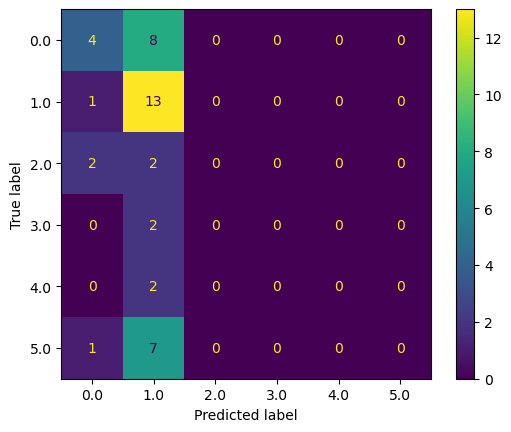

Confusion Matrix for test set


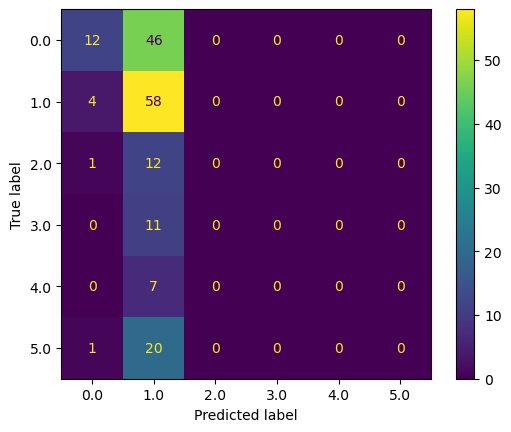

In [47]:
params = [{"damping": [0.5, 0.99]}, 
          {"convergence_iter": [10, 15]},
          #{"preference": [0.01]}
          ]
cls_name = "affinity_propagation"

clustering_classification(AffinityPropagation, cls_name, params, X_train, y_train, X_test, y_test, RANDOM_SEED, K_FOLDS)
train_acc_dict[cls_name] = train_acc
train_f1_dict[cls_name] = train_f1
test_acc_dict[cls_name] = test_acc
test_f1_dict[cls_name] = test_f1

# Save logs

In [48]:
print(train_acc_dict)
print(test_acc_dict)
print(train_f1_dict)
print(test_f1_dict)

writer.add_scalars("Train acc", train_acc_dict)
writer.add_scalars("Test acc", test_acc_dict)
writer.add_scalars("Train f1", train_f1_dict)
writer.add_scalars("Test f1", test_f1_dict)
writer.close()

{'knn': 0.6904761904761905, 'svm': 0.8809523809523809, 'log_reg': 0.6428571428571429, 'kmeans': 0.4523809523809524, 'affinity_propagation': 0.4523809523809524}
{'knn': 0.627906976744186, 'svm': 0.686046511627907, 'log_reg': 0.5523255813953488, 'kmeans': 0.46511627906976744, 'affinity_propagation': 0.46511627906976744}
{'knn': np.float64(0.6783052743643877), 'svm': np.float64(0.8766788766788766), 'log_reg': np.float64(0.5843317972350229), 'kmeans': np.float64(0.32952668246785893), 'affinity_propagation': np.float64(0.32952668246785893)}
{'knn': np.float64(0.5893007799940163), 'svm': np.float64(0.6682195328325615), 'log_reg': np.float64(0.4918614037365074), 'kmeans': np.float64(0.3117316112742102), 'affinity_propagation': np.float64(0.3117316112742102)}
